In [6]:
import numpy as np

import matplotlib.pyplot as plt

import os

from sklearn import metrics

from PIL import Image

from sklearn.metrics import confusion_matrix
import itertools

from scipy import stats
from skimage import io

from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Conv3D

from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split

In [7]:
# Loading the images data and the respective labels data into images & labels variables

def loadImages():
    images, labels, labelNumbered = [], [], []

    mIndex = 1
    mMainDir = "Crops"

    mCropLabels = os.listdir(mMainDir)
    
    for mCrop in mCropLabels:
        if mCrop.startswith("."):
            d = 0
            mIndex = mIndex - 1
        else:
            for mImage in os.listdir(mMainDir + "/" + mCrop):
                if mImage.startswith("."):
                    s = 0
                else:
                    mImage = np.load(mMainDir + "/" + mCrop + "/" + mImage)
                    images.append(mImage.flatten() )

                    labels.append(mCrop)
                    labelNumbered.append(mIndex)
            #print(mCrop)
        mIndex = mIndex + 1
    
    return images, labels, labelNumbered

In [8]:
images, labels, labelNumbered = loadImages()

image_data=np.array(images,dtype="float32")/255.0
mLabels=np.array(labelNumbered)

In [9]:
image_data.shape, mLabels.shape

((144, 10000), (144,))

In [10]:
# Splitting the data set into training and test data

X_train, X_test, y_train, y_test  = train_test_split(images, labelNumbered, train_size=0.7,test_size=0.3, random_state=42)

print("Training data: ", len(X_train) , " Training Labels: ", len(y_train))
print("Testing data: ", len(X_test), " Testing Labels: ", len(y_test) )

print("Sample size is: ", X_train[0].shape)

Training data:  100  Training Labels:  100
Testing data:  44  Testing Labels:  44
Sample size is:  (10000,)


In [11]:
# Function to display confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Loading generated GLCM features

In [12]:
m_xTrain = np.zeros((100, 100, 100, 48))

m_xTest = np.zeros((44, 100, 100, 48))

for mCount in np.arange(0, len(X_train)):
    mainDir = "Textures/Train"
    m_xTrain[mCount, :, :, :] = np.load(mainDir + '/field_texture_' + str(mCount) + '.npy')
    
for mCount in np.arange(0, len(X_test)):
    mainDir = "Textures/Test"
    m_xTest[mCount, :, :, :] = np.load(mainDir + '/field_texture_' + str(mCount) + '.npy')
    
m_xTrain.shape, m_xTest.shape

((100, 100, 100, 48), (44, 100, 100, 48))

In [13]:
train_data = []

for mCount in np.arange(0, len(X_train)):
    train_data.append(m_xTrain[mCount, :, :, :].flatten())
    
test_data = []

for mCount in np.arange(0, len(X_test)):
    test_data.append(m_xTest[mCount, :, :, :].flatten())

## Making data ready for neural network based classification

In [14]:
m_Training = np.zeros((len(X_train), 100, 100, 1))
m_Testing = np.zeros((len(X_test), 100, 100, 1))

for mCount in np.arange(0, len(X_train)):
    m_Training[mCount, :, :] = X_train[mCount].reshape(100, 100, 1)
    
for mCount in np.arange(0, len(X_test)):
    m_Testing[mCount, :, :] = X_test[mCount].reshape(100, 100, 1)
    
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [15]:
# Converting Train and Test Labels to One Hot Encoding

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
y_mTrain = enc.fit_transform(y_train.reshape(-1,1)).toarray()

y_mTest = enc.fit_transform(y_test.reshape(-1,1)).toarray()
# merge with main df bridge_df on key values

In [16]:
from tensorflow.keras import utils

y_mTrain = utils.to_categorical(y_train)

y_mTest = utils.to_categorical(y_test)

In [17]:
y_mTrain.shape

(100, 6)

In [18]:
m_Training = m_Training.reshape(100, 100, 100)
m_Testing = m_Testing.reshape(44, 100, 100)

m_Training = m_Training / 255.0
m_Testing = m_Testing / 255.0

## Neural network on gray scale images

In [25]:
# Create the model
model = Sequential()

model.add(Flatten(input_shape=(100, 100)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")

In [26]:
model.fit(m_Training, y_mTrain, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 2.3367 - accuracy: 0.0900
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 1.9898 - accuracy: 0.2000
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 1.8967 - accuracy: 0.1500
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 1.7836 - accuracy: 0.2900
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 1.7868 - accuracy: 0.3100
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 1.6647 - accuracy: 0.4400
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 1.7430 - accuracy: 0.2500
Epoch 8/10
13/13 [==============================] - 0s 6ms/step - loss: 1.6528 - accuracy: 0.3300
Epoch 9/10
13/13 [==============================] - 0s 5ms/step - loss: 1.5927 - accuracy: 0.3400
Epoch 10/10
13/13 [==============================] - 0s 7ms/step - loss: 1.5415 - accuracy: 0.4100


The accuracy of the neural network classifier on gray scale images is: 0.3181818181818182


Classification report of neural network classifier for gray scale images is - 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.36      1.00      0.53        14
           5       0.00      0.00      0.00        11

    accuracy                           0.32        44
   macro avg       0.07      0.20      0.11        44
weighted avg       0.11      0.32      0.17        44





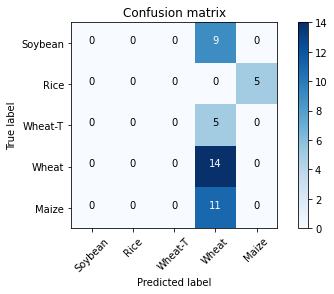

In [27]:
pred = model.predict(m_Testing)
pred = np.argmax(pred, axis= 1 )

print("The accuracy of the neural network classifier on gray scale images is: " + str(metrics.accuracy_score(y_test, pred)))

print("\n\nClassification report of neural network classifier for gray scale images is - \n{}\n".format(
    metrics.classification_report(y_test, pred, zero_division=0)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)

class_names = ["Soybean", "Rice", "Wheat-T", "Wheat", "Maize"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

#plt.savefig("SVM_Confusion_Matrix.pdf", format='pdf', bbox_inches='tight')

plt.show()

## Neural network on GLCM images

In [22]:
# Create the model
model = Sequential()

model.add(Flatten(input_shape=(100, 100, 48)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [23]:
model.fit(m_xTrain, y_mTrain, batch_size=1, epochs=10, verbose=1)

Epoch 1/10
100/100 [==============================] - 29s 287ms/step - loss: 104630.6484 - accuracy: 0.2300
Epoch 2/10
100/100 [==============================] - 26s 259ms/step - loss: 7653.0967 - accuracy: 0.1800
Epoch 3/10
100/100 [==============================] - 26s 259ms/step - loss: 1761.2223 - accuracy: 0.2700
Epoch 4/10
100/100 [==============================] - 27s 268ms/step - loss: 726.2810 - accuracy: 0.2400
Epoch 5/10
100/100 [==============================] - 26s 264ms/step - loss: 1591.7944 - accuracy: 0.2800
Epoch 6/10
100/100 [==============================] - 27s 271ms/step - loss: 366.8038 - accuracy: 0.2600
Epoch 7/10
100/100 [==============================] - 28s 283ms/step - loss: 801.0952 - accuracy: 0.2700
Epoch 8/10
100/100 [==============================] - 28s 285ms/step - loss: 25.7333 - accuracy: 0.3000
Epoch 9/10
100/100 [==============================] - 27s 267ms/step - loss: 1780.0387 - accuracy: 0.2800
Epoch 10/10
100/100 [============================

The accuracy of the neural network classifier on glcm images is: 0.25


Classification report of neural network classifier on glcm images is - 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        14
           5       0.25      1.00      0.40        11

    accuracy                           0.25        44
   macro avg       0.05      0.20      0.08        44
weighted avg       0.06      0.25      0.10        44





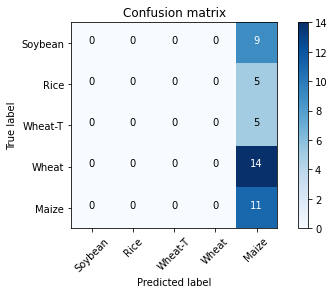

In [24]:
pred = model.predict(m_xTest)
pred = np.argmax(pred, axis= 1 )

print("The accuracy of the neural network classifier on glcm images is: " + str(metrics.accuracy_score(y_test, pred)))

print("\n\nClassification report of neural network classifier on glcm images is - \n{}\n".format(
    metrics.classification_report(y_test, pred, zero_division=0)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)

class_names = ["Soybean", "Rice", "Wheat-T", "Wheat", "Maize"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

#plt.savefig("SVM_Confusion_Matrix.pdf", format='pdf', bbox_inches='tight')

plt.show()